In [229]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

from dsa_analysis import load_config, visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
import main
from main import RNNLayer
import ast
import DSA
import copy
from notebooks.utils_rnn import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load config

In [230]:
config = load_config("../config.yaml")
taskset = "PDM"

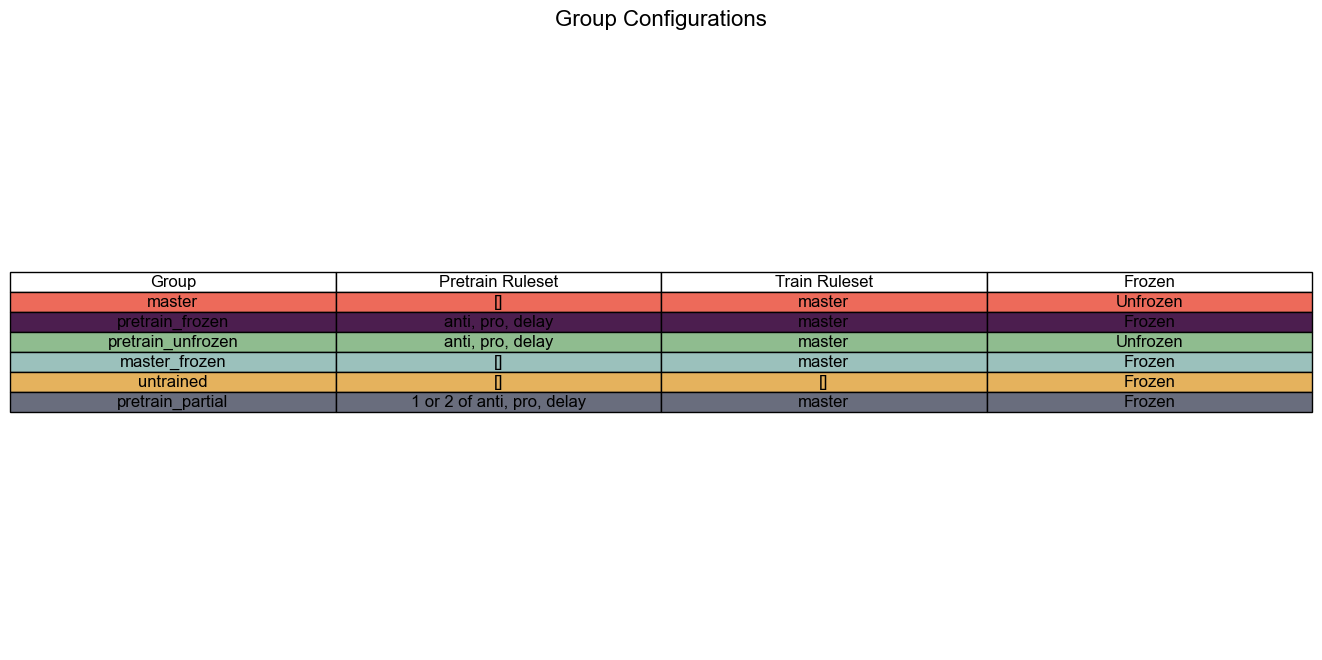

In [231]:
visualize_reduced_plots(color_mapping)

### Get dissimilarities

#### Computation dynamics

In [232]:
path = f"../data/dissimilarities/{taskset}/"
df = get_dataframe(path, taskset)



In [233]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_selected = df.copy()
df_selected["group2"] = df_selected["group2"].apply(lambda x: "pretrain_partial" if x in groups_selected else x)
df_selected["group1"] = df_selected["group1"].apply(lambda x: "pretrain_partial" if x in groups_selected else x)
groups_base = ["master"]
groups_selected = ["pretrain_partial", "pretrain_frozen", "pretrain_unfrozen"]
df_selected = df_selected[df_selected["group1"].isin(groups_base) & df_selected["group2"].isin(groups_selected)]

In [234]:
def discriminate_df(df_selected, groups_base, criteria):
    for measure in measures:
        fig, ax = plt.subplots(
            nrows=1, ncols=1, figsize=(20, 10), sharex=True, sharey=True
        )

        # Iterate over each group pair
        for group in groups_base:
            # ax = axes[groups_base.index(group)]

            # Prepare palette dictionary for hue levels
            hue_palette = {
                hue: color_mapping.get(hue, "gray")
                for hue in df_selected["group2"].unique()
            }

            # Plot a violin plot for the dissimilarity distribution
            sns.violinplot(
                data=df_selected[
                    (df_selected["group1"] == group)
                    & (df_selected["measure"] == measure)
                ],
                x=criteria,
                y="dissimilarity",
                hue="group2",
                ax=ax,
                inner="quart",
                palette=hue_palette,
            )
            ax.set_title(f"{group}", fontsize=8)
            ax.set_xlabel("")
            ax.set_ylabel("")

        # Adjust layout
        plt.suptitle(
            f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

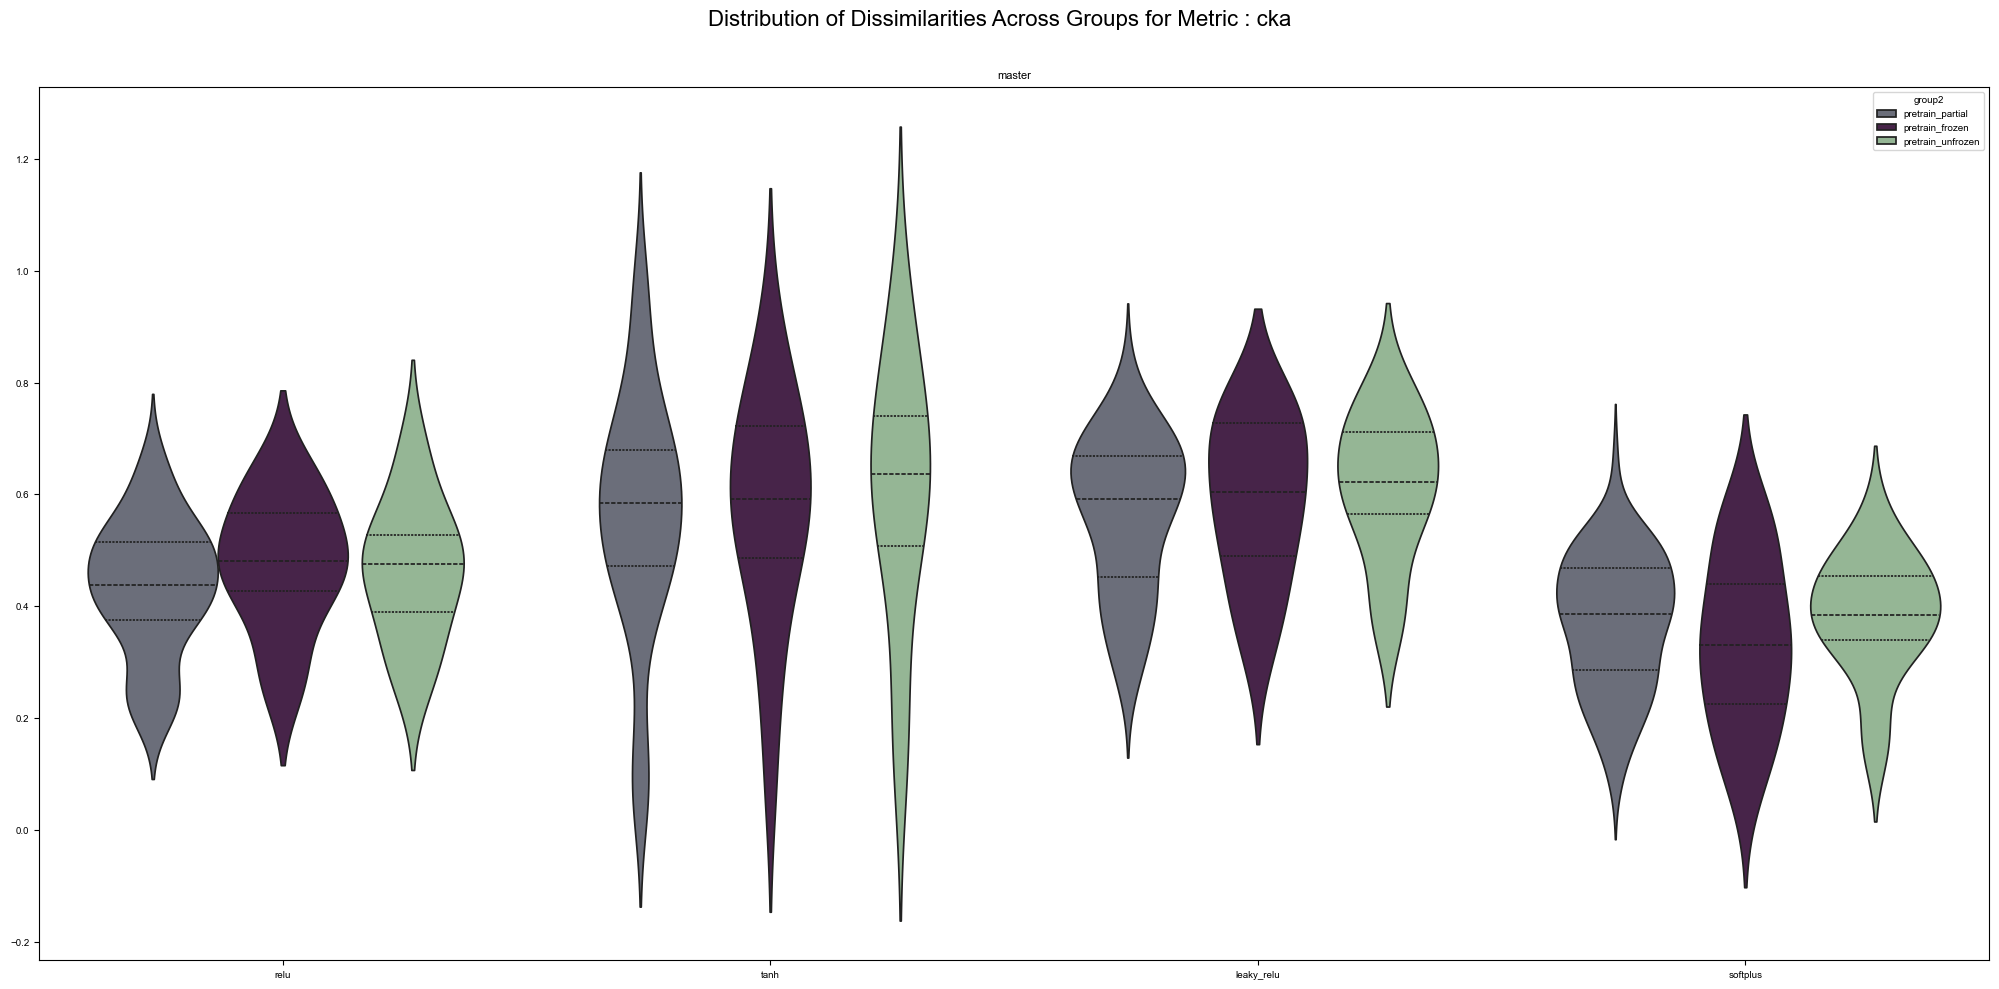

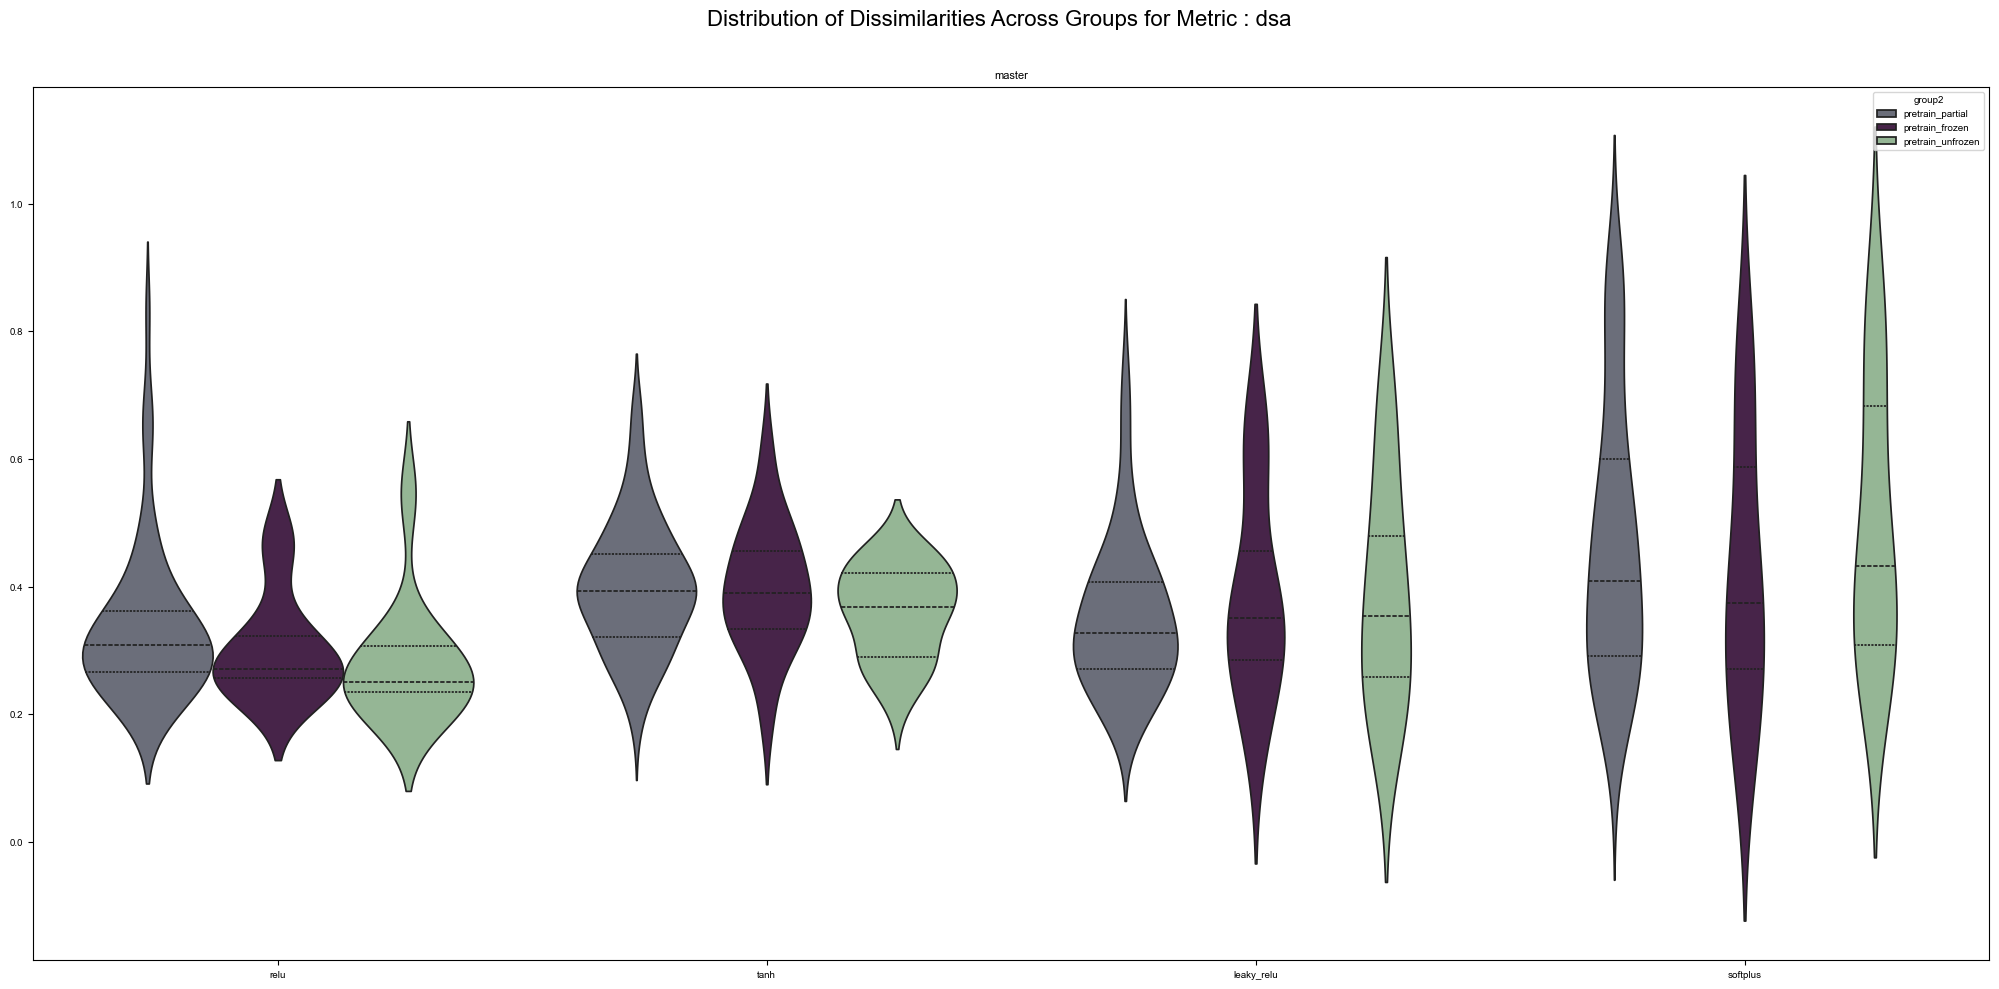

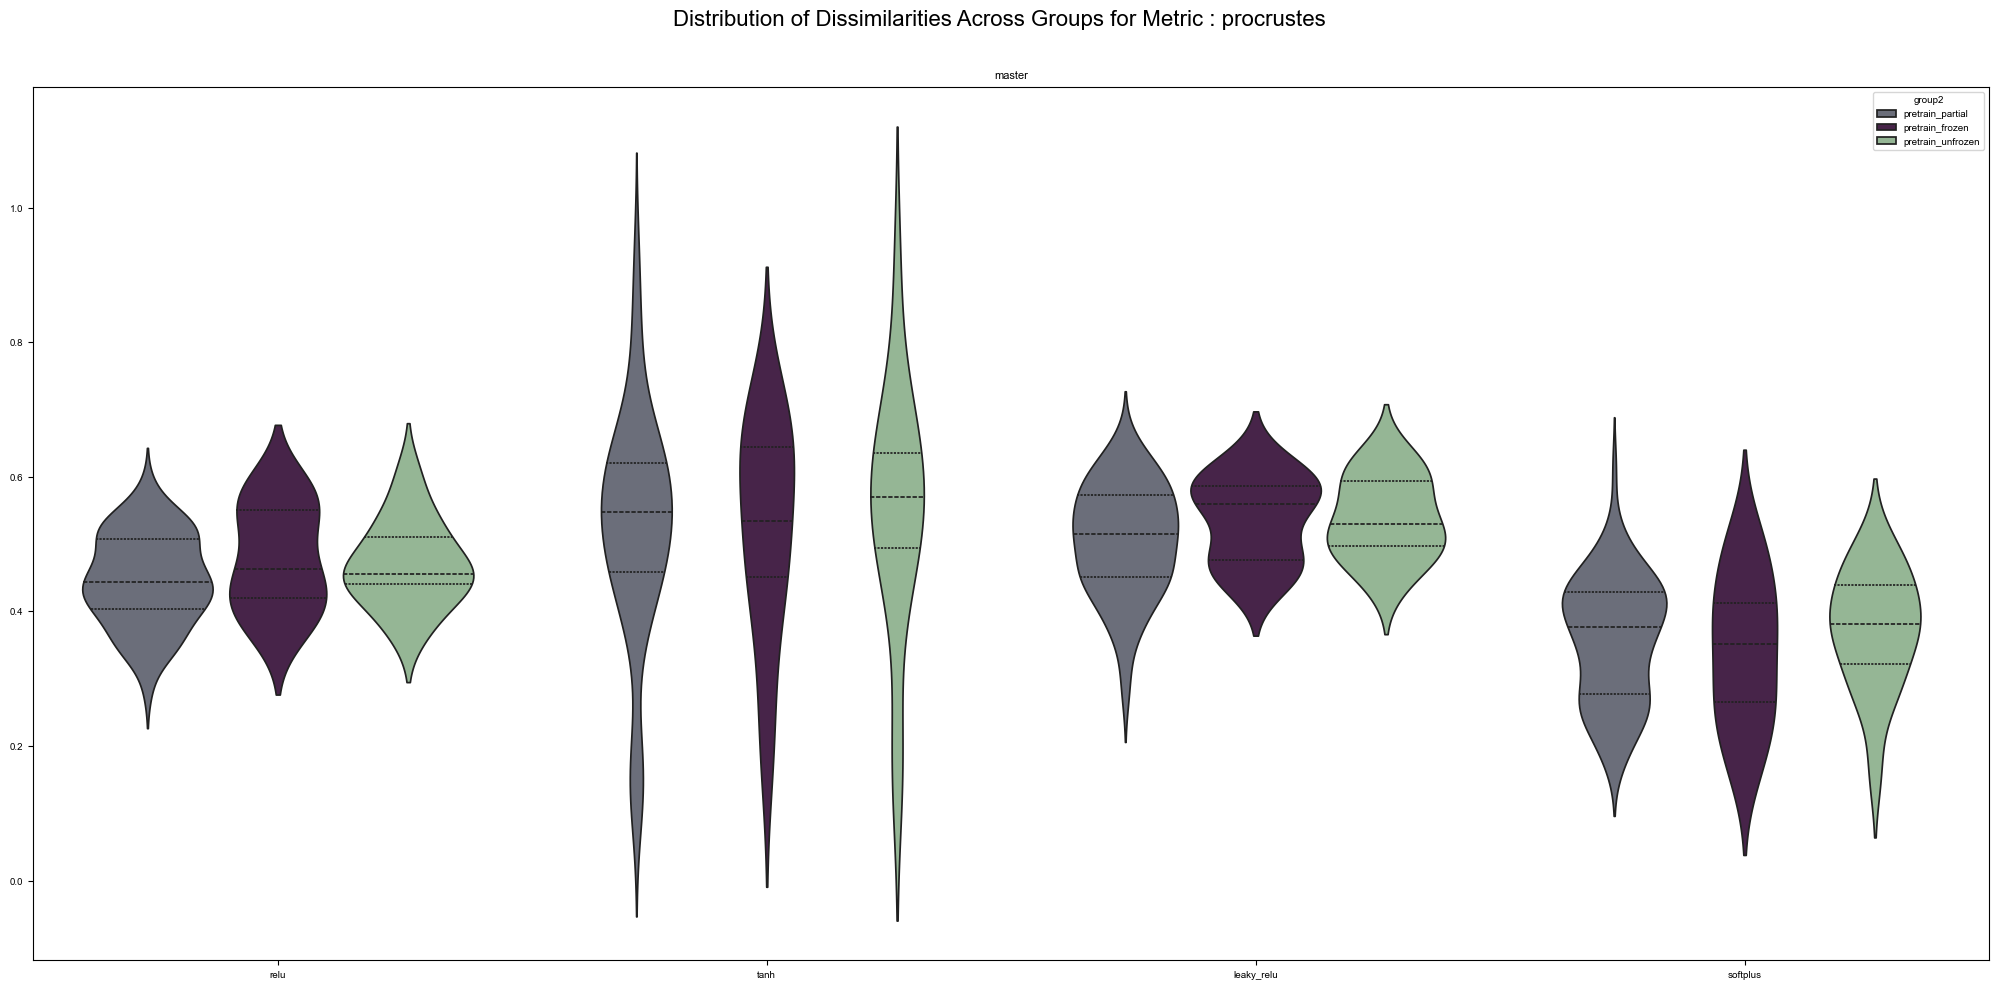

In [235]:

discriminate_df(df_selected, groups_base, criteria="activation")

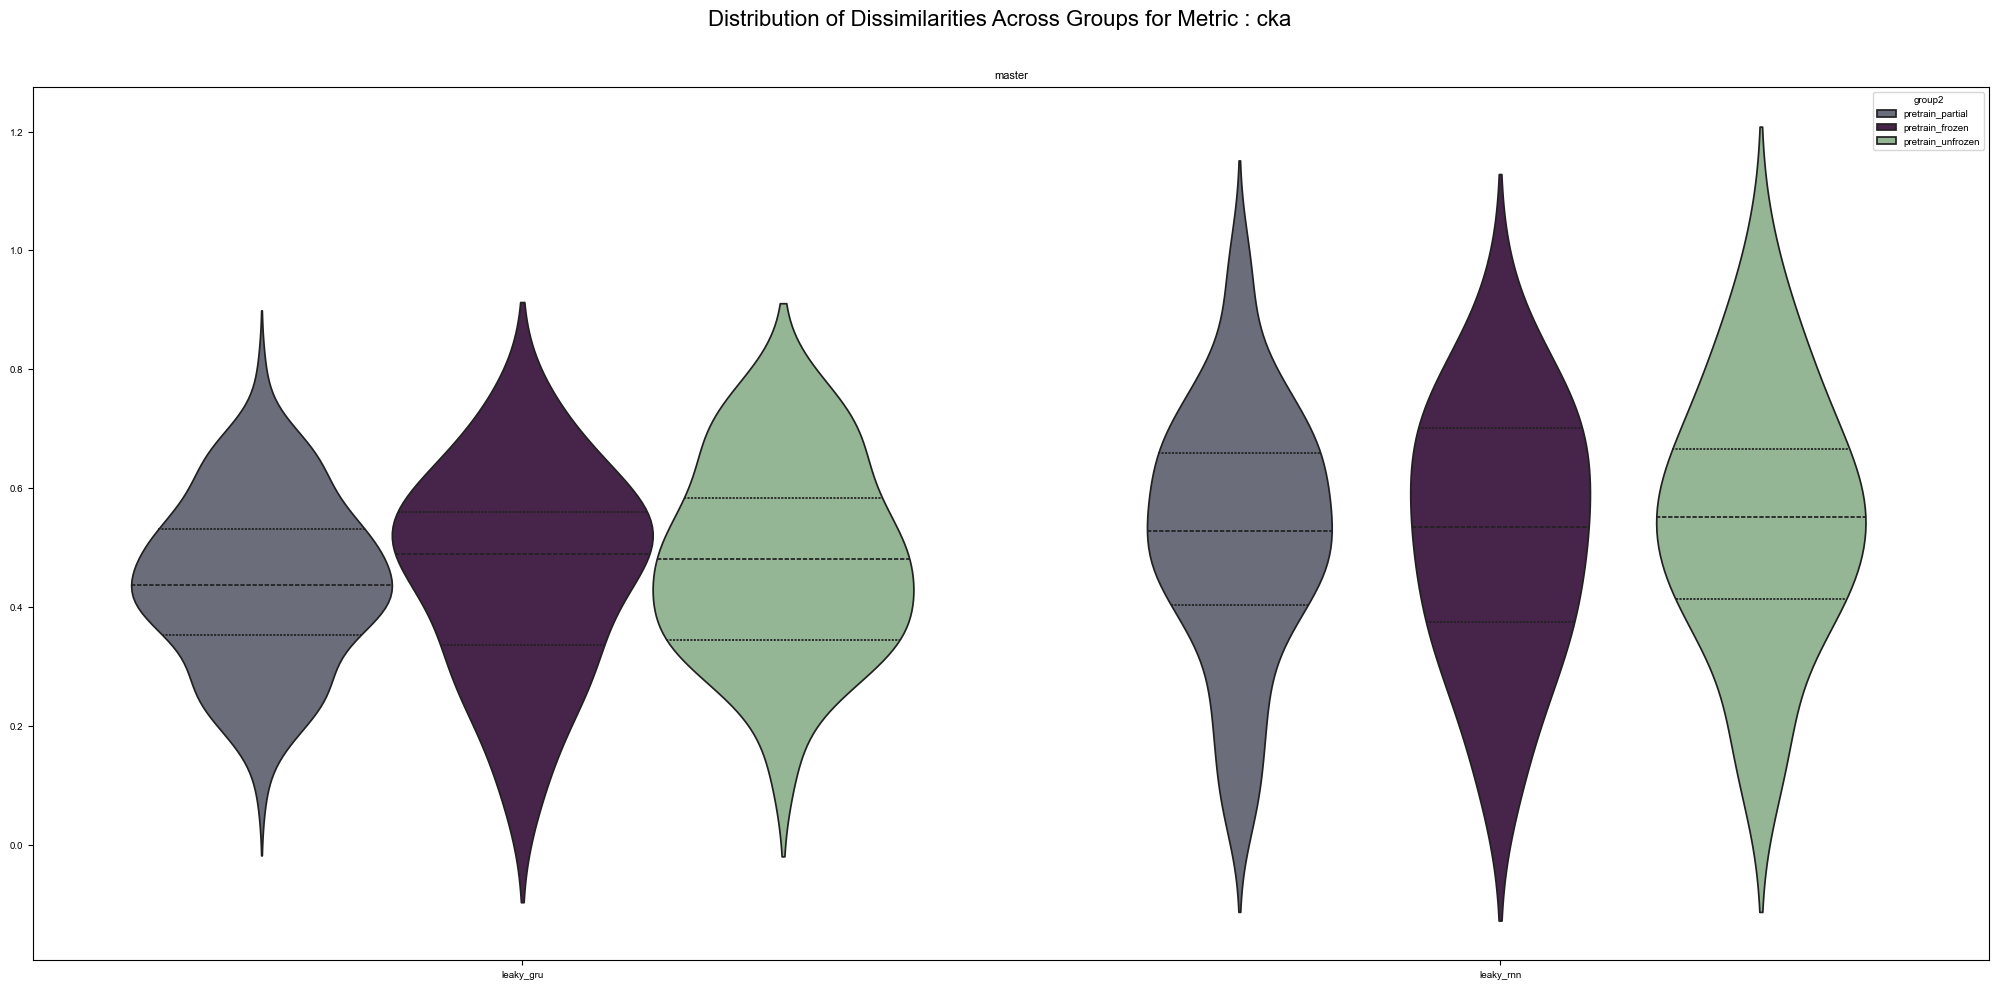

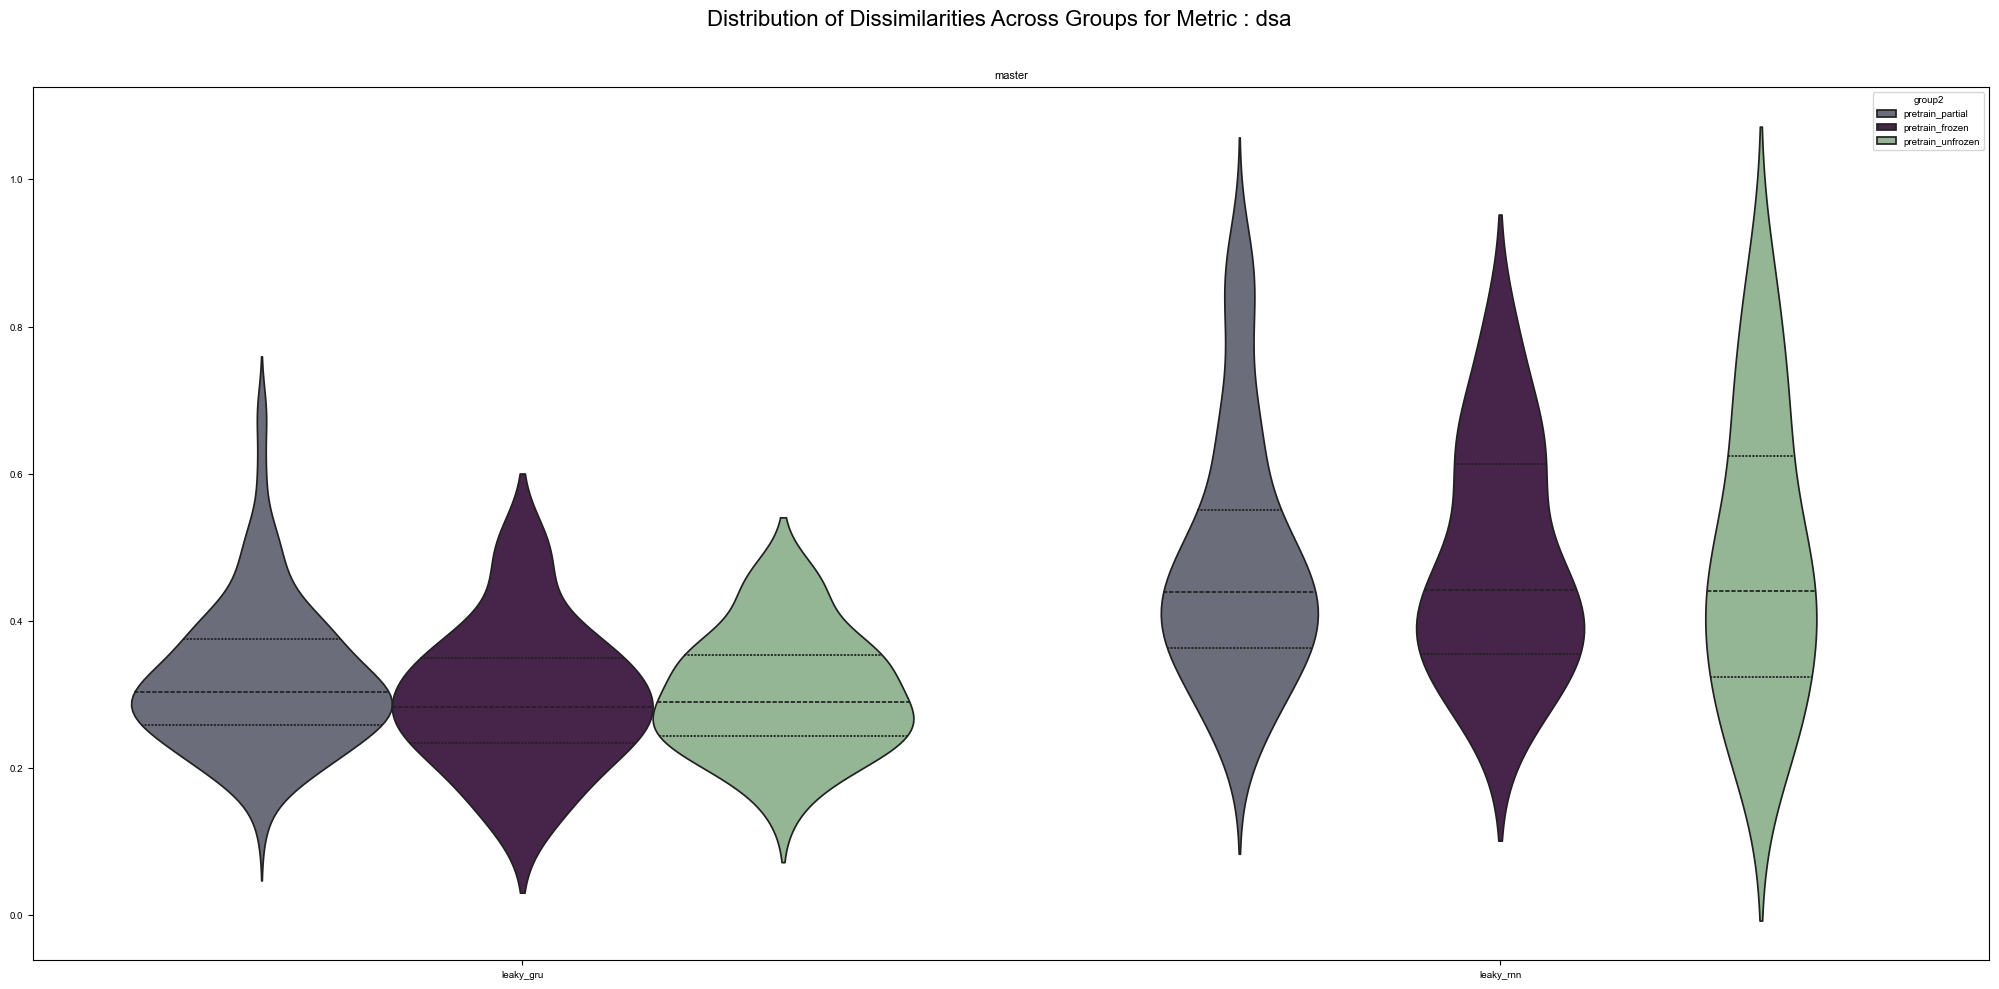

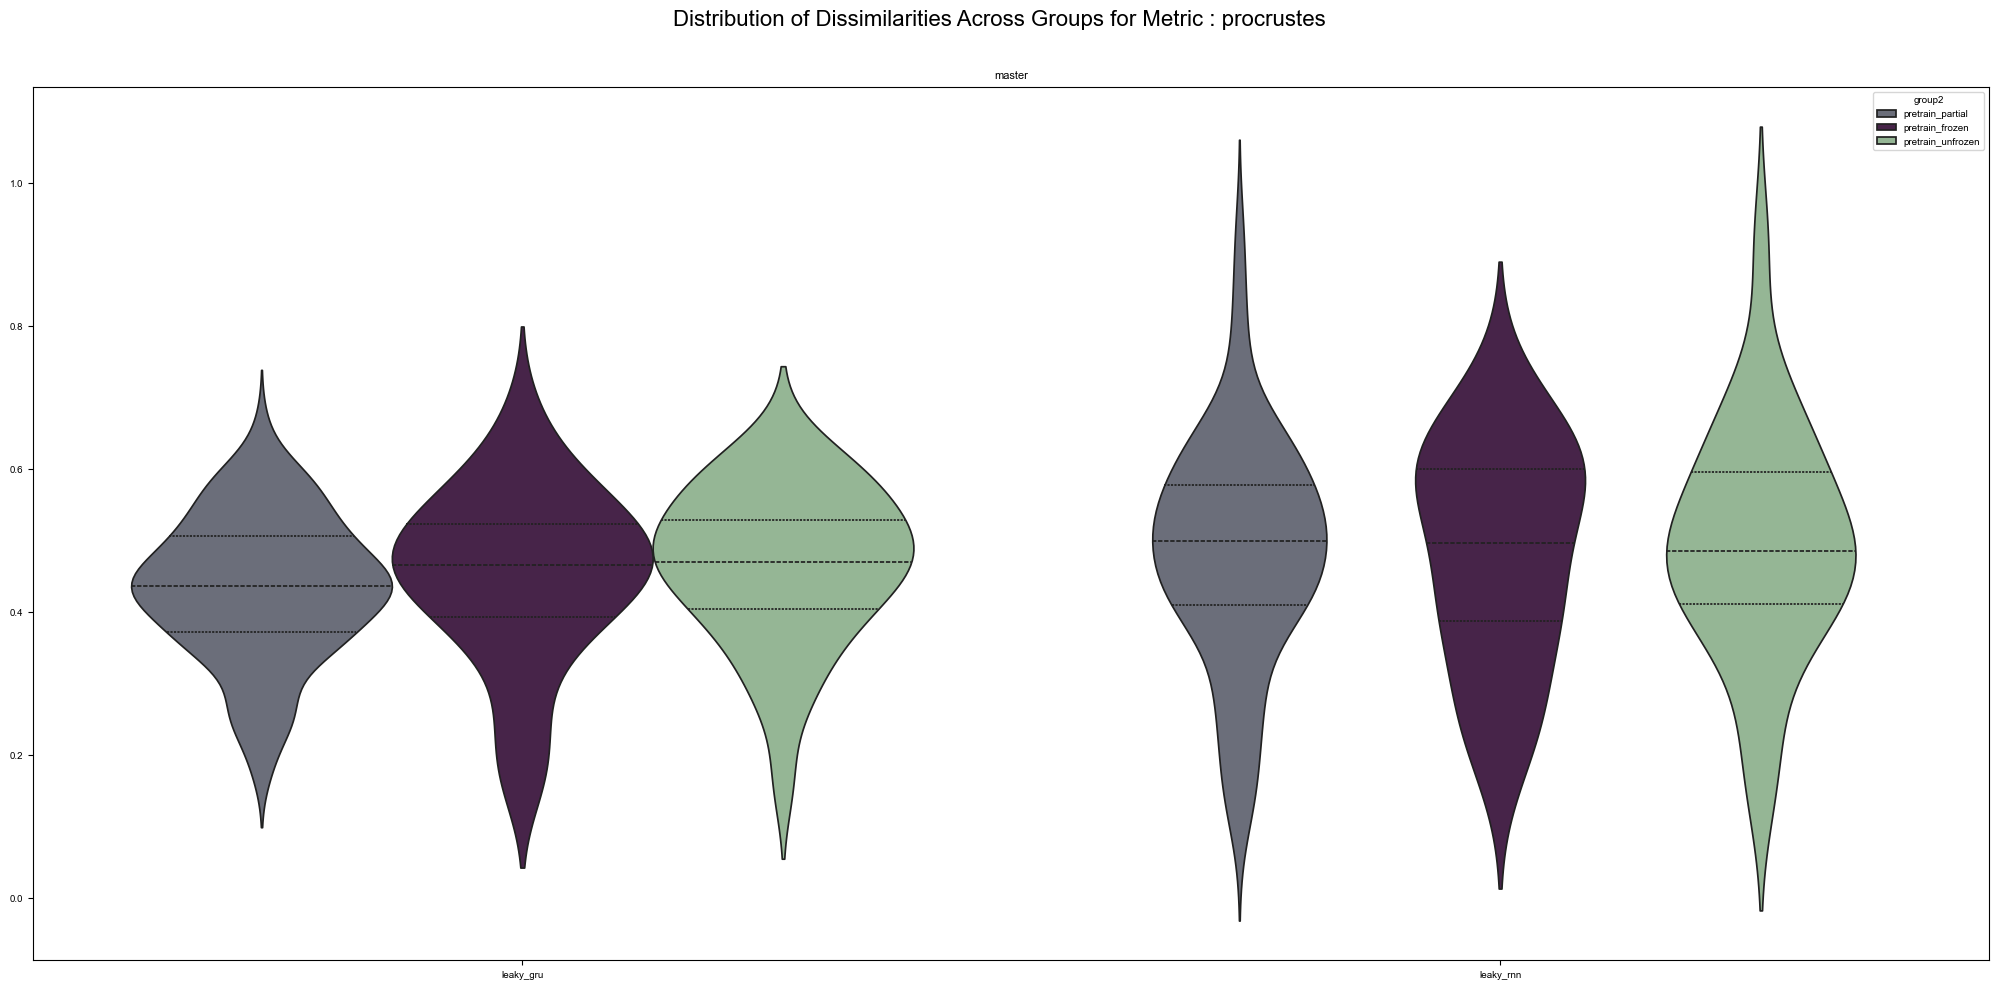

In [236]:
discriminate_df(df_selected, groups_base, criteria="model_type")

In [237]:
df_selected, models_trained_per_group = select_df(df)

In [238]:
df_selected

,model_type,activation,hidden_size,lr,batch_size,group1,group2,measure,dissimilarity,accuracy_1,accuracy_2
2,leaky_gru,relu,128,0.010,64,untrained,master,cka,4.131438e-01,-1.000000,1.000000
12,leaky_gru,relu,128,0.010,64,master_frozen,master,cka,4.258682e-01,0.900244,1.000000
20,leaky_gru,relu,128,0.010,64,master,untrained,cka,4.131438e-01,1.000000,-1.000000
21,leaky_gru,relu,128,0.010,64,master,master_frozen,cka,4.258682e-01,1.000000,0.900244
22,leaky_gru,relu,128,0.010,64,master,master,cka,5.475983e-04,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
16795,leaky_rnn,tanh,256,0.001,128,pretrain_unfrozen,pretrain_delay_frozen,procrustes,6.247184e-01,1.000000,1.000000
16796,leaky_rnn,tanh,256,0.001,128,pretrain_unfrozen,pretrain_basic_anti_frozen,procrustes,7.561041e-01,1.000000,0.954836
16797,leaky_rnn,tanh,256,0.001,128,pretrain_unfrozen,pretrain_basic_delay_frozen,procrustes,6.349755e-01,1.000000,0.499545
16798,leaky_rnn,tanh,256,0.001,128,pretrain_unfrozen,pretrain_frozen,procrustes,6.490532e-01,1.000000,0.551069


In [239]:
groups_selected = [
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
]
# map all the groups in groups_selected to pretrain_partial
df_grouped = df_selected.copy()
df_grouped["group2"] = df_grouped["group2"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
df_grouped["group1"] = df_grouped["group1"].apply(
    lambda x: "pretrain_partial" if x in groups_selected else x
)
groups_base = ["master"]
groups_selected = ["untrained", "master_frozen", "pretrain_partial", "pretrain_frozen", "pretrain_unfrozen"]
df_grouped= df_grouped[
    df_grouped["group1"].isin(groups_base)
    & df_grouped["group2"].isin(groups_selected)
]

In [240]:
df_grouped["group2"].unique()

array(['untrained', 'master_frozen', 'pretrain_partial',
       'pretrain_frozen', 'pretrain_unfrozen'], dtype=object)

In [241]:
def discriminate_df(df_selected, groups_base, criteria):
    for measure in measures:
        fig, ax = plt.subplots(
            nrows=1, ncols=1, figsize=(20, 10), sharex=True, sharey=True
        )

        # Iterate over each group pair
        for group in groups_base:
            # ax = axes[groups_base.index(group)]

            # Prepare palette dictionary for hue levels
            hue_palette = {
                hue: color_mapping.get(hue, "gray")
                for hue in df_selected["group2"].unique()
            }

            # Plot a violin plot for the dissimilarity distribution
            sns.violinplot(
                data=df_selected[
                    (df_selected["group1"] == group)
                    & (df_selected["measure"] == measure)
                ],
                x="group2",
                y="dissimilarity",
                hue="group2",
                ax=ax,
                inner="quart",
                palette=hue_palette,
            )
            ax.set_title(f"{group}", fontsize=8)
            ax.set_xlabel("")
            ax.set_ylabel("")

        # Adjust layout
        plt.suptitle(
            f"Distribution of Dissimilarities Across Groups for Metric : {measure}",
            fontsize=16,
        )
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

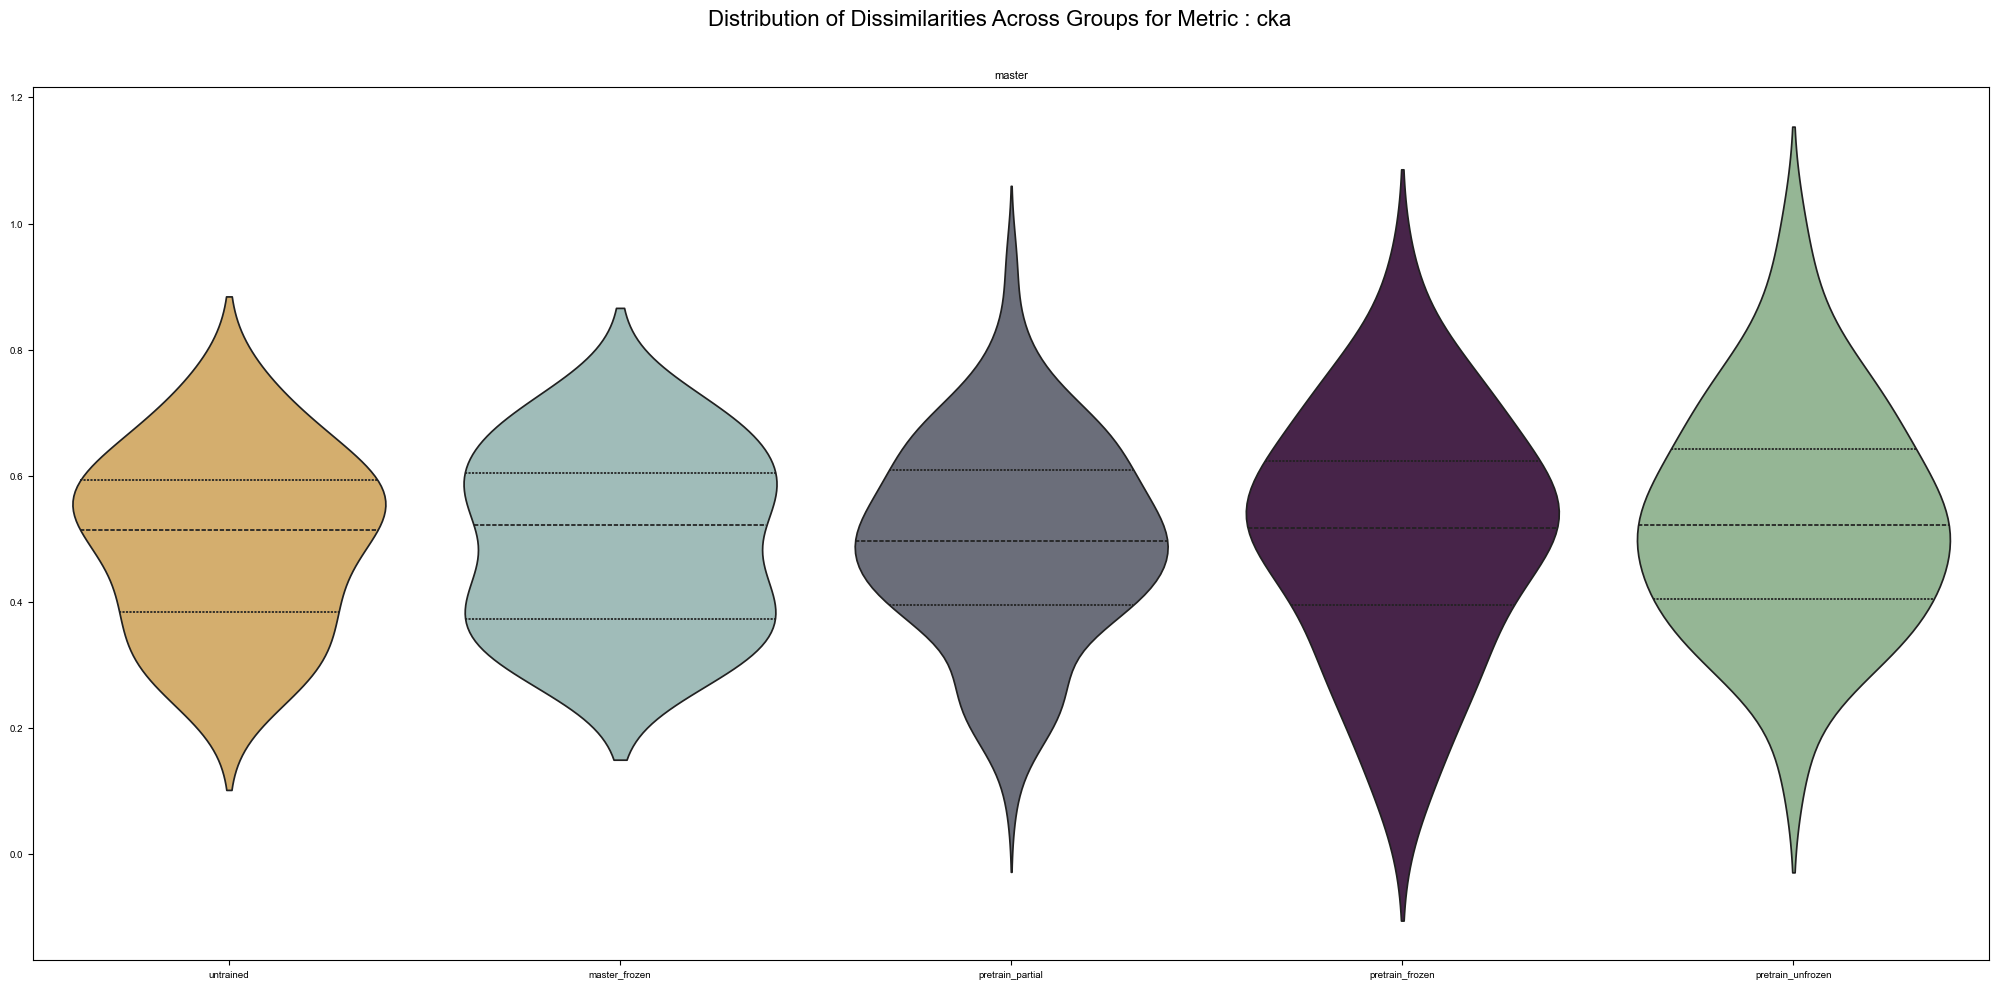

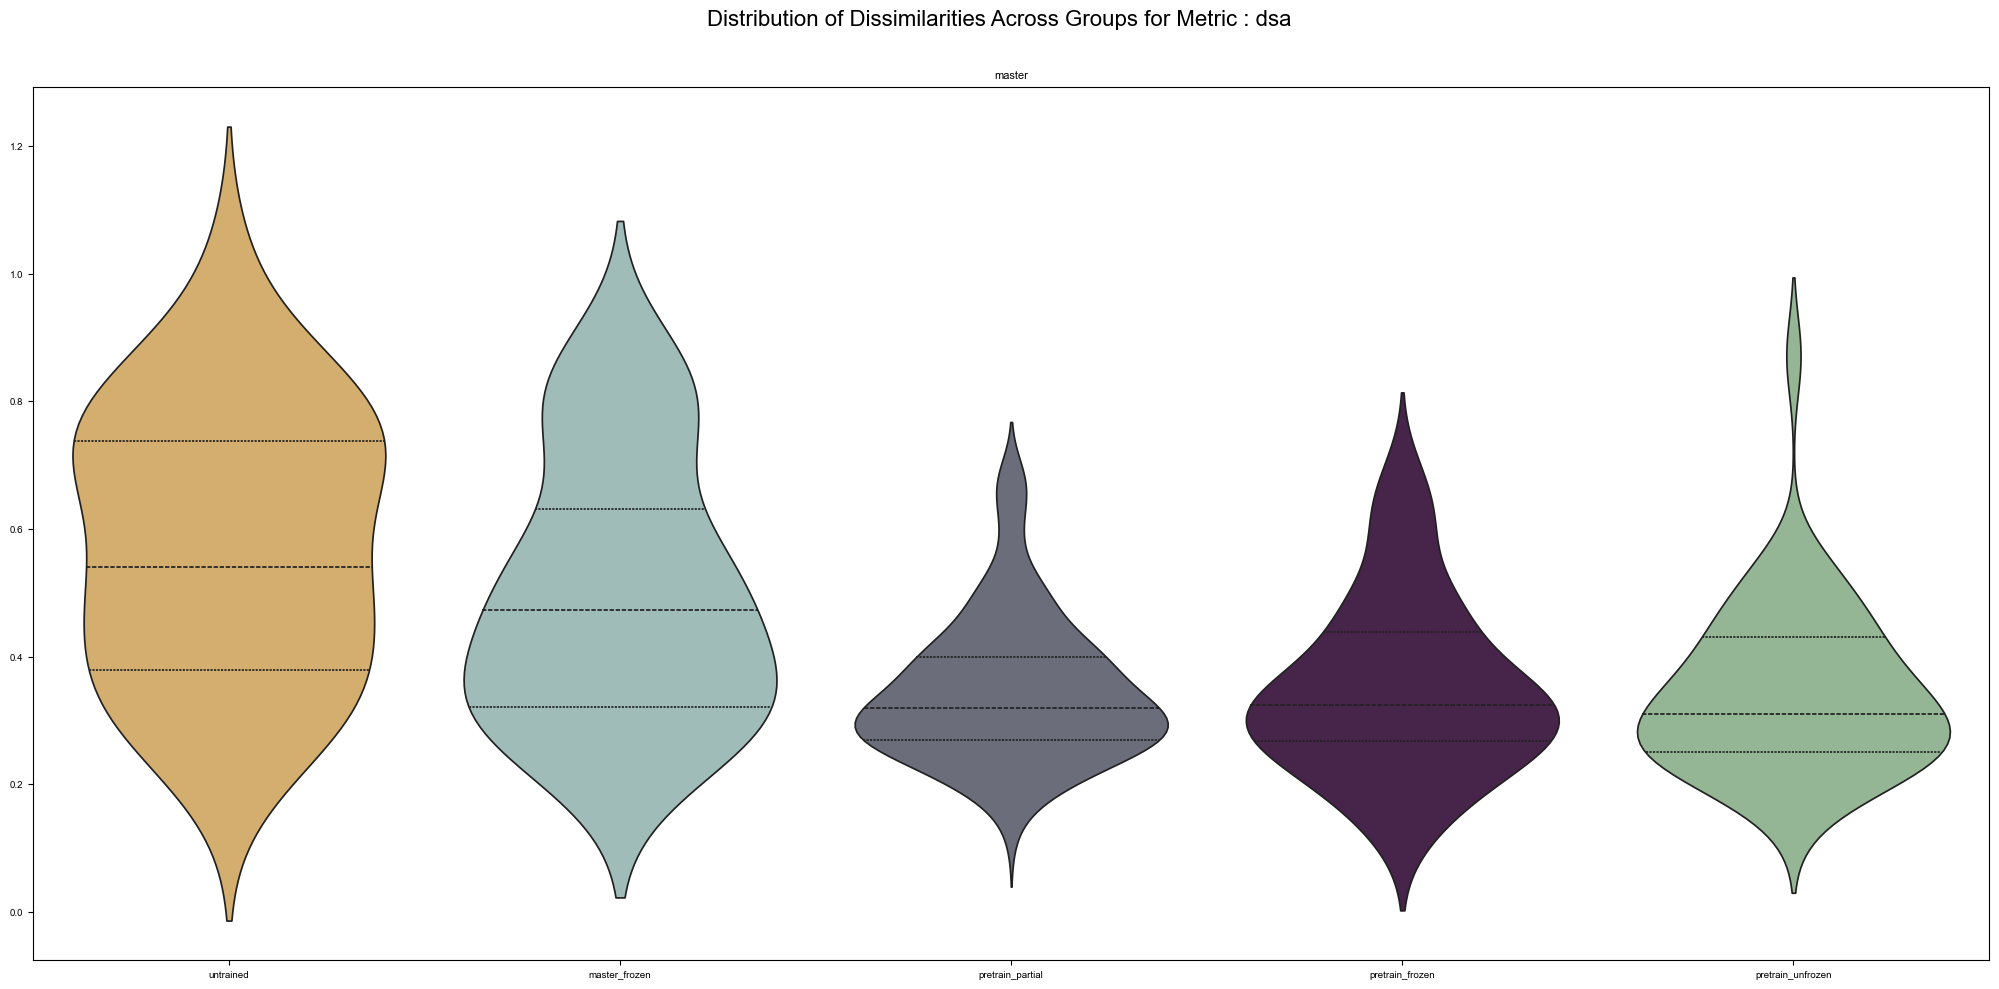

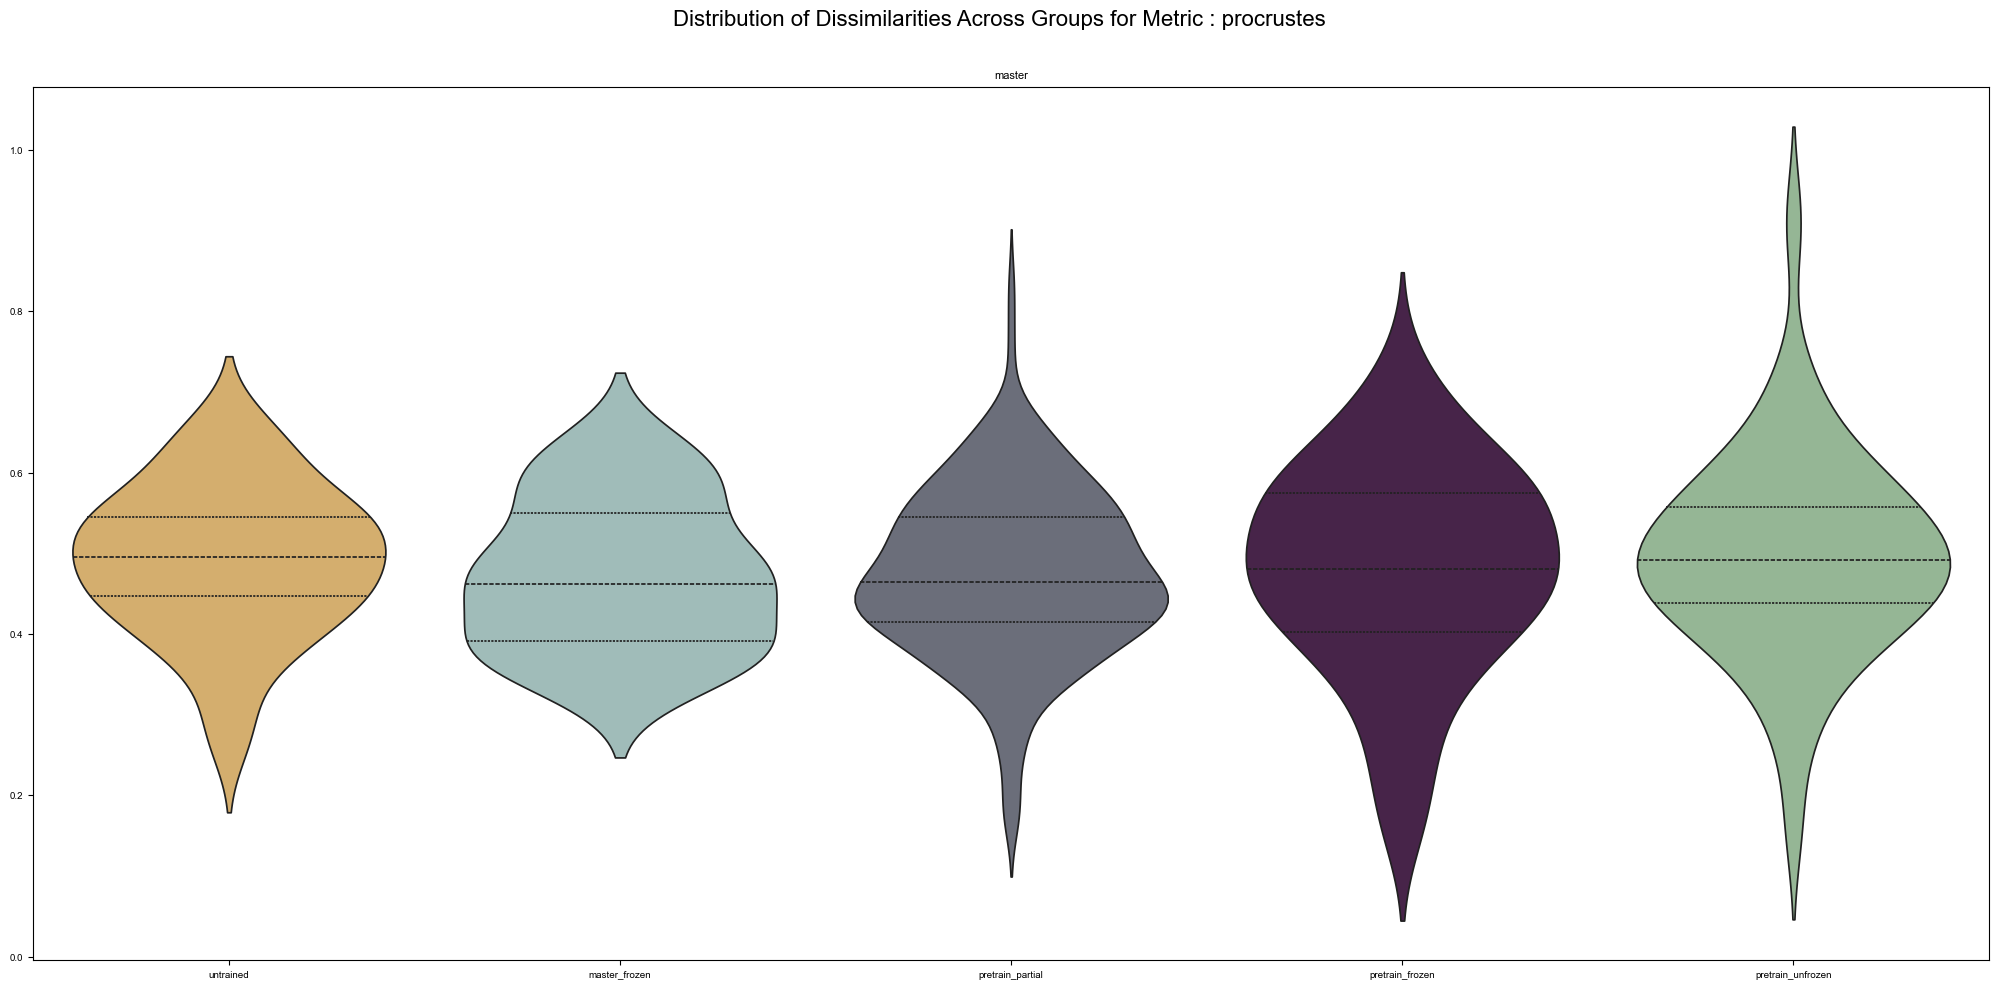

In [242]:
discriminate_df(df_grouped, groups_base, criteria="activation")

In [243]:
# Group by 'group1', 'group2', and 'measure', then calculate median dissimilarities
median_dissimilarities = (
    df_selected.groupby(["group1", "group2", "measure"])["dissimilarity"].mean().reset_index()
)

# Pivot the data to prepare it for the heatmap
pivot_table = median_dissimilarities.pivot_table(
    index="group1", columns="group2", values="dissimilarity"
)

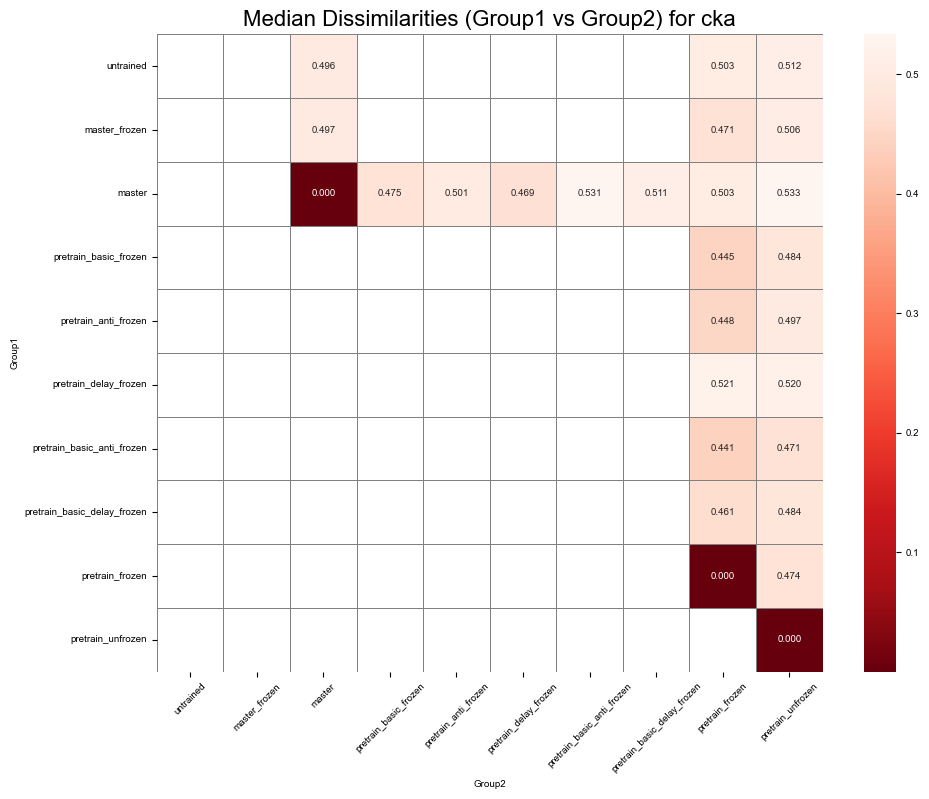

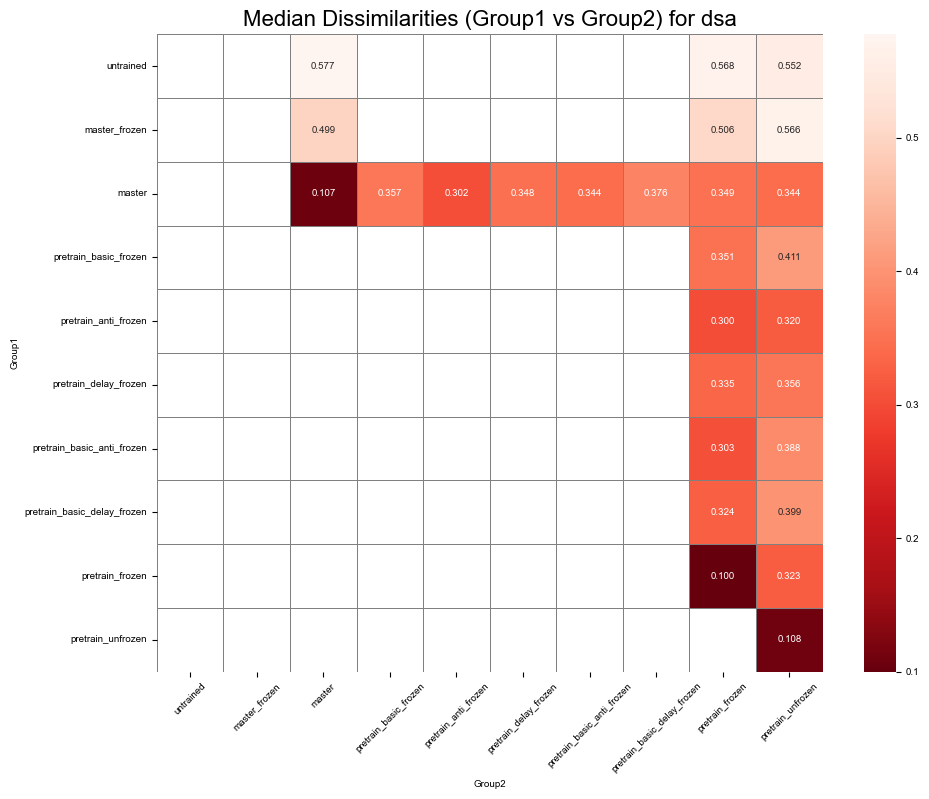

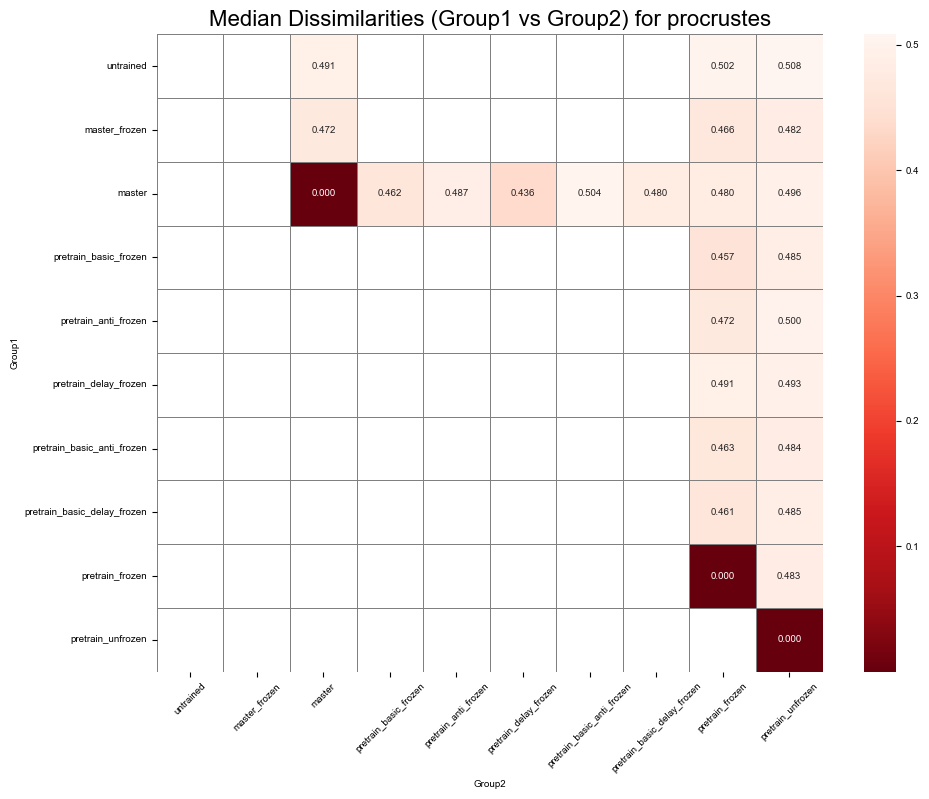

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming median_dissimilarities DataFrame is defined

# Define the desired order for groups
groups = [
    "untrained",
    "master_frozen",
    "master",
    "pretrain_basic_frozen",
    "pretrain_anti_frozen",
    "pretrain_delay_frozen",
    "pretrain_basic_anti_frozen",
    "pretrain_basic_delay_frozen",
    "pretrain_frozen",
    "pretrain_unfrozen",
]

# Unique measures
measures = df_selected["measure"].unique()

# Plot heatmap for each measure
for measure in measures:
    # Filter the pivot table for the specific measure
    measure_pivot = median_dissimilarities[
        median_dissimilarities["measure"] == measure
    ].pivot(index="group1", columns="group2", values="dissimilarity")

    # Reorder the rows and columns according to the specified groups
    measure_pivot = measure_pivot.reindex(index=groups, columns=groups)

    # Create a mask for the lower triangle (excluding the diagonal)
    mask = np.tril(np.ones_like(measure_pivot, dtype=bool), -1)

    # Create a heatmap
    #TODO : same scale for all metrics : Same min max for all metrics
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        measure_pivot,
        annot=True,
        fmt=".3f",
        cmap="Reds_r",
        cbar=True,
        linewidths=0.5,
        linecolor="gray",
        mask=mask,  # Apply the mask to show only the upper triangle including the diagonal
    )
    plt.title(f"Median Dissimilarities (Group1 vs Group2) for {measure}", fontsize=16)
    plt.xlabel("Group2")
    plt.ylabel("Group1")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

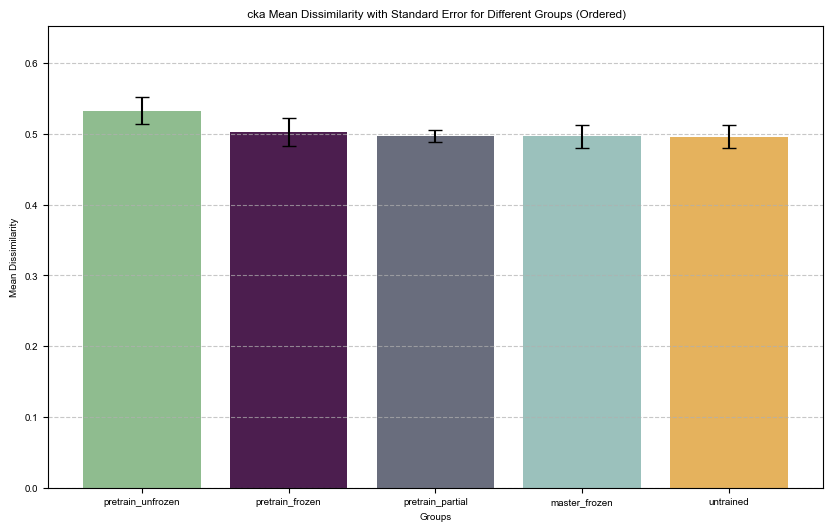

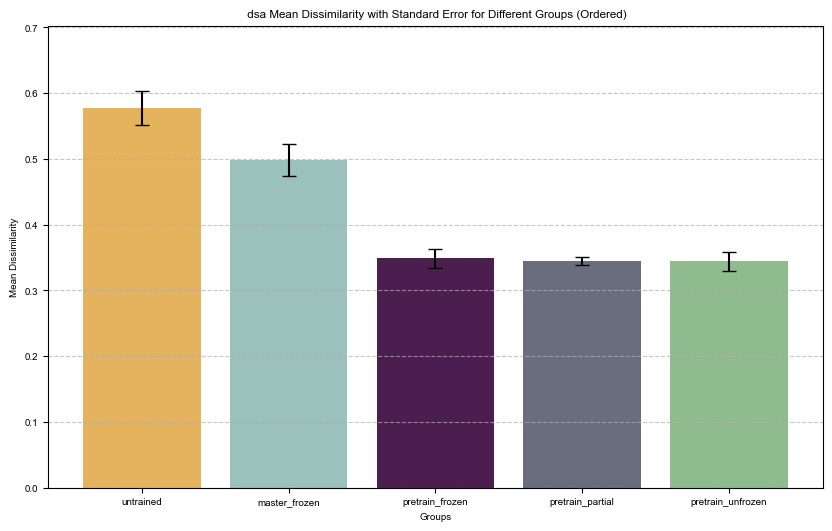

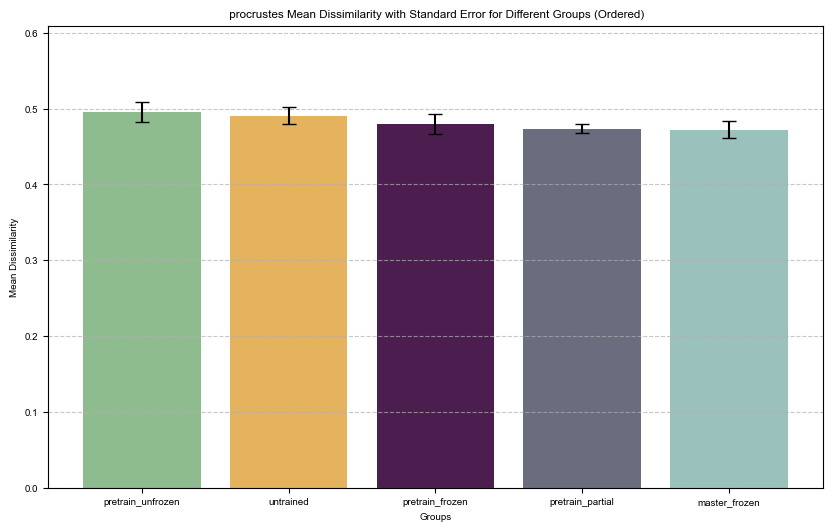

In [245]:
from numpy import mean


for measure in measures:
    # Create a bar chart with error bars
    df_standard = t_standart_error_dissimilarity_all_groups(df_selected, measure)
    groups, mean_dissimilarities, standard_errors = (
        df_standard["group"],
        df_standard["mean_dissimilarities"],
        df_standard["standard_errors"],
    )
    # Step 1: Zip the data together and sort by mean_dissimilarities in descending order
    sorted_data = sorted(zip(mean_dissimilarities, standard_errors, groups), reverse=True)

    # Step 2: Unzip the sorted data back into separate lists
    mean_dissimilarities, standard_errors, groups = zip(*sorted_data)

    # Step 3: Create the bar chart
    plt.figure(figsize=(10, 6))
    colors = [color_mapping.get(group, "gray") for group in groups]
    plt.bar(groups, mean_dissimilarities, yerr=standard_errors, capsize=5, color=colors)
    plt.xlabel("Groups")
    plt.ylabel("Mean Dissimilarity")
    plt.title(f" {measure} Mean Dissimilarity with Standard Error for Different Groups (Ordered)")
    plt.ylim(
        0, max(mean_dissimilarities) + max(standard_errors) + 0.1
    )  # Adjust the y-axis limit if needed
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)

    # Display the plot
    plt.show()

In [246]:
df_test = t_test_all_pairs(df_selected, "dsa")

In [247]:
df_test

,pairs,p_value,adjusted_p_value
0,"(untrained, master_frozen)",2.850783e-02,4.072547e-02
1,"(untrained, pretrain_partial)",1.808264e-17,1.808264e-16
2,"(untrained, pretrain_frozen)",9.363734e-12,3.121245e-11
3,"(untrained, pretrain_unfrozen)",4.567192e-12,2.283596e-11
4,"(master_frozen, untrained)",2.850783e-02,4.072547e-02
5,"(master_frozen, pretrain_partial)",1.332017e-09,3.330042e-09
6,"(master_frozen, pretrain_frozen)",2.306122e-06,3.843537e-06
7,"(master_frozen, pretrain_unfrozen)",7.368208e-07,1.473642e-06
8,"(pretrain_partial, untrained)",1.808264e-17,1.808264e-16
9,"(pretrain_partial, master_frozen)",1.332017e-09,3.330042e-09


/var/folders/rg/xgkyjs4945d6ckms1nn6v0jm0000gn/T/ipykernel_5117/2788346849.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="comparison", y="adjusted_p_value", data=bar_data, palette=palette)


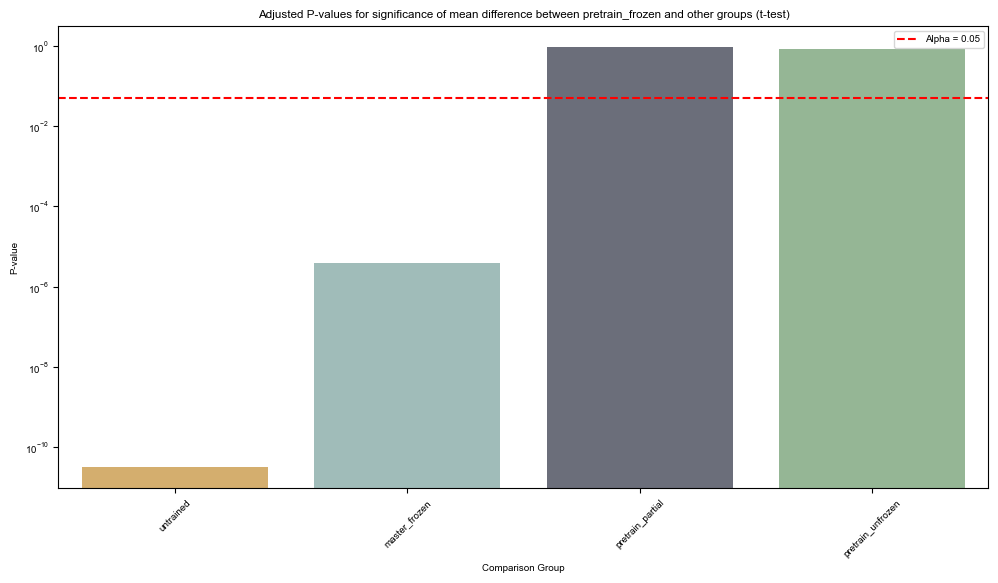

In [248]:
# Extract relevant comparisons where pretrain_frozen is involved
pretrain_frozen_comparisons = df_test[
    df_test["pairs"].apply(lambda x: "pretrain_frozen" in x)
]

# Create a dataframe for the bar plots
bar_data = pretrain_frozen_comparisons.copy()
bar_data["comparison"] = bar_data["pairs"].apply(
    lambda x: x[0] if x[1] == "pretrain_frozen" else x[1]
)

# Create a palette using your color mapping
palette = {
    group: color_mapping[group]
    for group in bar_data["comparison"].unique()
    if group in color_mapping
}

# Bar plot for p-values where pretrain_frozen is one of the groups
plt.figure(figsize=(12, 6))
ax = sns.barplot(x="comparison", y="adjusted_p_value", data=bar_data, palette=palette)
plt.yscale("log")  # Use log scale for better visibility of p-values
plt.axhline(y=0.05, color="red", linestyle="--", label="Alpha = 0.05")
plt.title(
    "Adjusted P-values for significance of mean difference between pretrain_frozen and other groups (t-test)"
)
plt.xlabel("Comparison Group")
plt.ylabel("P-value")
plt.xticks(rotation=45)
plt.legend()
plt.show()